**PLANET DATASET: UNDERSTANDING THE AMAZON FROM SPACE**

In [1]:
# Imporing Required Libraries

import pandas as pd
import numpy as np

In [2]:
# Libraries for Data Visualisation

import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline

In [3]:
# Libraries for Loading and Preparing dataset

from os import listdir
from numpy import zeros
from numpy import asarray
from numpy import savez_compressed
from pandas import read_csv
from keras import backend
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import os
import time
from sklearn.metrics import fbeta_score
import tensorflow as tf
from keras.optimizers import SGD
import sys
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [4]:
# Libraries for loading models

from tensorflow.keras.models import load_model

In [5]:
# Libraries for train-test-split

from sklearn.model_selection import train_test_split

In [6]:
# Loading the train and test datasets

train_datasets = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')
test_image_datasets = '../input/planets-dataset/planet/planet/test-jpg/'
train_image_datasets = '../input/planets-dataset/planet/planet/train-jpg/'

In [7]:
# Load the train_datasets
train_datasets

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


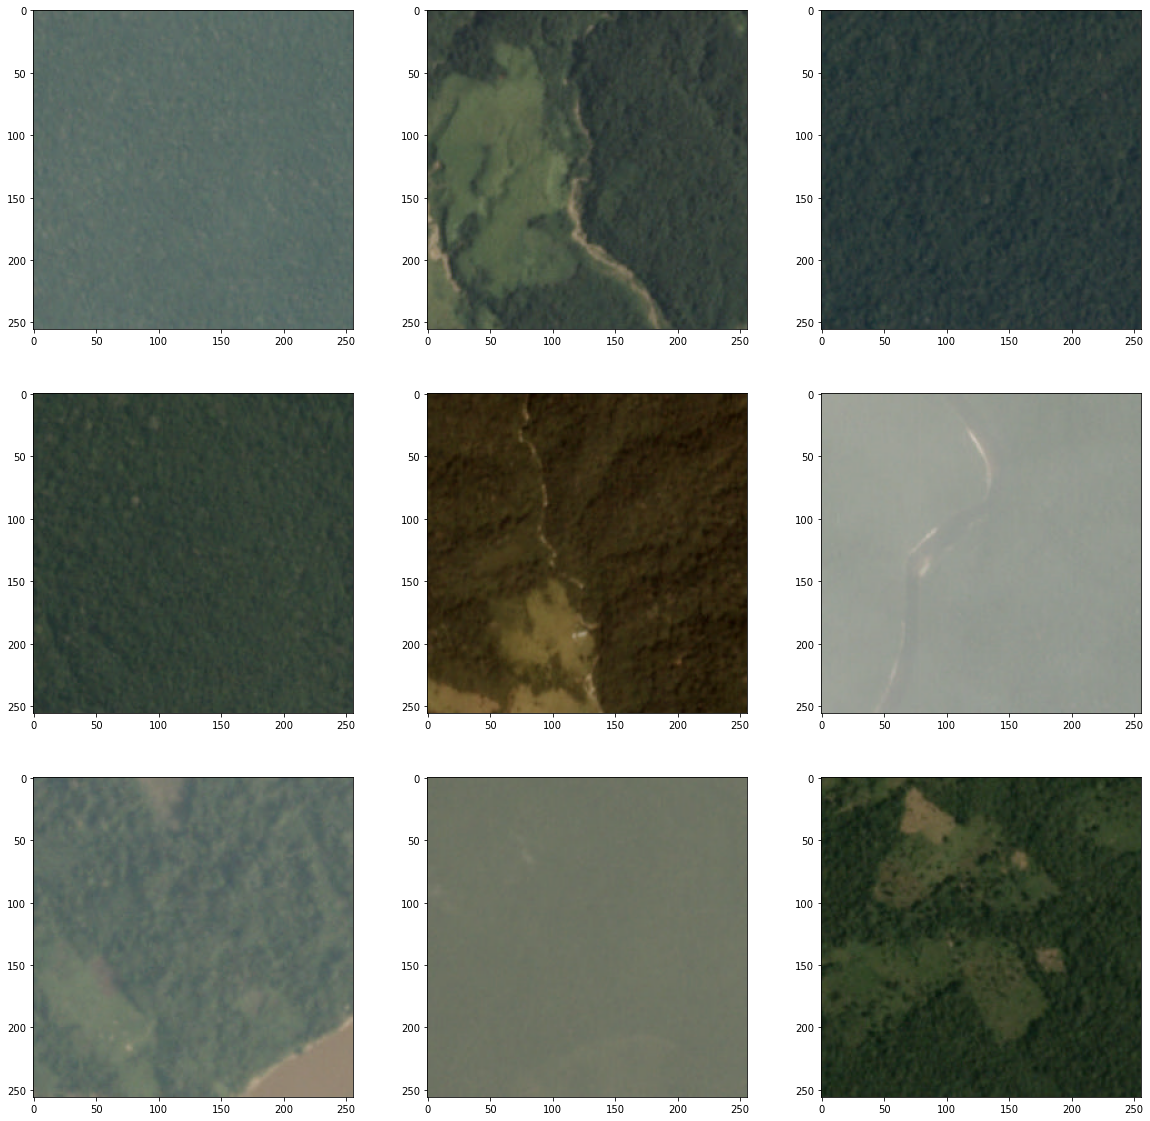

In [8]:
# View the first 9 train images from the Planet Dataset

plt.figure(figsize=( 20 , 20 ))

folder = 'planet/train-jpg/'

for i in range(9):
    pyplot.subplot(330 + 1 + i)
    
    # Define File
    file = train_image_datasets + 'train_' + str(i) + '.jpg'
    
    # Load image pixel
    image = imread(file)
    
    # Plot pixel data
    pyplot.imshow(image)
    
plt.show()


In [9]:
# Remove the individual tags from the train_datasets by spltting with empty strings

datasets_list = []
for tag_values in train_datasets.tags.values:
    datasets = tag_values.split(' ')
    for dataset in datasets:
        if dataset not in datasets_list:
            datasets_list.append(dataset)
            
# Check dataset list

len(datasets_list)

17

In [10]:
# Order datasets in strings 

datasets_list.sort()

In [11]:
# Creating tag_datasets and inverse_datasets_map

tag_mappings = {datasets_list[i]: i for i in range(len(datasets_list))}

inverse_datasets_map = {i:datasets_list[i] for i in range(len(datasets))}

# Create a mapping of files to tags

def map_files(mapping_csv):
    mapping = dict()
    for i in range(len(mapping_csv)):
        name, tags = mapping_csv['image_name'][i], mapping_csv['tags'][i]
        mapping[name] = tags.split(' ')
    return mapping

file_mapping = map_files(train_datasets)

# Creating a one hot encoding

def encode_one_hot(tags, mapping):
    
    #creating empty vector
    encoding = np.zeros(len(mapping), dtype = 'uint8')
    
    #mark 1 for each tag in the vector
    for tag in tags:
        encoding[mapping[tag]] = 1
    return encoding 

In [12]:
# Preparing the image dataset

# Load the images
def load_dataset(path, file_mapping, tag_mappings):
    photos = list()
    targets = list()
    
# For files in the directory
    for file in os.listdir(train_image_datasets):
        
        # Load images
        photo = load_img(path + file, target_size=(64,64))
        
        # Converting to numpy array
        photo = img_to_array(photo, dtype='uint8')
        
        # Tags
        tags = file_mapping[file[:-4]]
        
        # One hot encode tags
        target = encode_one_hot(tags, tag_mappings)
        
        #stores
        photos.append(photo)
        targets.append(target)
        
    X = np.asarray(photos,dtype='uint8')
    Y = np.asarray(targets,dtype='uint8')
    return X,Y

X, Y = load_dataset(train_image_datasets, file_mapping, tag_mappings)
print(X.shape, Y.shape)

# Compressing X and Y arrays into one single file
np.savez_compressed('planet_data.npz', X, Y)

(40479, 64, 64, 3) (40479, 17)


In [13]:
# Load dataset

data = np.load('./planet_data.npz')
X,Y = data['arr_0'], data['arr_1']
print('load_dataset: ', X.shape, Y.shape)

load_dataset:  (40479, 64, 64, 3) (40479, 17)


In [14]:
# Split train and val sets

X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.3, random_state = 42)
print('shapes: ', X_train.shape, X_val.shape, Y_val.shape)

shapes:  (28335, 64, 64, 3) (12144, 64, 64, 3) (12144, 17)


In [15]:
# Evaluating the Fscore metric
# Create a funcion to compute evaluation metrics

def fbeta(Y_true, Y_pred, beta=2):
    
    #clip predictors
    Y_pred = backend.clip(Y_pred, 0, 1)
    
    #Calculating elements
    tp = backend.sum(backend.round(backend.clip(y_true * Y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_true - Y_pred, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - Y_pred, 0, 1)), axis=1)
    
    #Calculating precision
    p = tp / (tp + fp + backend.epsilon())
    
    #Calculate recall
    r = tp / (tp + fn + backend.epsilon())
    
    #Calculate fbeta, averaged across each class
    bb = beta ** 2
    fbeta_score = backend.mean(1 + bb) * (p * r) / (bb * p * r + backend.epsilon())
    
    return fbeta_score

>*Create base model_PLANET*

In [16]:
# Initialise the model_planet
model_planet = tf.keras.models.Sequential()

# add conv and pooling layers
model_planet.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=[64, 64, 3]))
model_planet.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_planet.add(tf.keras.layers.MaxPool2D(2,2))

# add second conv and pooling layers
model_planet.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_planet.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_planet.add(tf.keras.layers.MaxPool2D(2,2))

# add third conv and pooling layers
model_planet.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_planet.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_planet.add(tf.keras.layers.MaxPool2D(2,2))

In [17]:
# add flattening and output layers
model_planet.add(tf.keras.layers.Flatten())
model_planet.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_planet.add(tf.keras.layers.Dense(17, activation='sigmoid'))

In [18]:
# Compilled the created model_planet
opt = SGD(lr=0.01, momentum=0.9)
model_planet.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])

trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.3, random_state=1)

In [19]:
# Plot learning curves
def summerize_diagostics(history):
    
    #plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    
    #plot accuracy
    plt.subplot(212)
    plt.title('Fbeta')
    plt.plot(history.history['fbeta'], color='blue', label='train')
    plt.plot(history.history['val_fbeta'], color='orange', label='test')
    
    #save plot to file
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_plot.png')
    plt.close()

In [20]:
#Create data generators
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

In [21]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters=128, kernel_size=3, input_shape=(128, 128, 3)))
    model.add(Flatten())
    model.add(Dense(17, activation='sigmoid'))
    opt = Adam(lr=1e-2)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[multi_label_acc, fbeta])
    
    return model

In [27]:
train_datasets

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [28]:
train_datasets['image_name'] = train_datasets['image_name'].apply(lambda x: x[:-4])
train_datasets.head()

,image_name,tags
0,tra,haze primary
1,tra,agriculture clear primary water
2,tra,clear primary
3,tra,clear primary
4,tra,agriculture clear habitation primary road


In [29]:
train_datasets.to_csv('submission.csv', index=False, header=1)